In [1]:
from price_loaders.tradingview import load_asset_price


SYMBOL = "SET:BH"
df = load_asset_price(SYMBOL, 10000, "1D", None)
df = df.set_index("time")
df.columns = ["Open", "High", "Low", "Close", "Volume", "pe_ratio"]
df

Open       High        Low      Close  \
time                                                                    
1989-12-15 09:00:00+07:00   17.22762   21.46826   17.22762   20.93818   
1989-12-18 09:00:00+07:00   20.80566   21.33574   19.08290   19.74550   
1989-12-19 09:00:00+07:00   19.48046   19.87802   18.02274   19.87802   
1989-12-20 09:00:00+07:00   19.74550   20.14306   19.74550   20.01054   
1989-12-21 09:00:00+07:00   19.74550   20.14306   19.74550   20.01054   
...                              ...        ...        ...        ...   
2024-08-09 09:00:00+07:00  249.00000  254.00000  248.00000  253.00000   
2024-08-13 09:00:00+07:00  252.00000  254.00000  244.00000  245.00000   
2024-08-14 09:00:00+07:00  246.00000  247.00000  242.00000  245.00000   
2024-08-15 09:00:00+07:00  242.00000  244.00000  238.00000  241.00000   
2024-08-16 09:00:00+07:00  243.00000  246.00000  243.00000  243.00000   

                                 Volume   pe_ratio  
time                                                
1989-12-15 09:00:00+07:00  2.123451e+06        NaN  
1989-12-18 09:00:00+07:00  1.293388e+06        NaN  
1989-12-19 09:00:00+07:00  1.125867e+06        NaN  
1989-12-20 09:00:00+07:00  1.254149e+06        NaN  
1989-12-21 09:00:00+07:00  5.538781e+05        NaN  
...                                 ...        ...  
2024-08-09 09:00:00+07:00  2.614060e+06  28.906687  
2024-08-13 09:00:00+07:00  4.453967e+06  27.992642  
2024-08-14 09:00:00+07:00  2.455266e+06  27.992642  
2024-08-15 09:00:00+07:00  3.481418e+06  27.535619  
2024-08-16 09:00:00+07:00  1.766456e+06  27.764131  

[7115 rows x 6 columns]

In [2]:
import pandas as pd
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

/Users/premchotipanit/Documents/page_contents/backtesting/.pixi/envs/default/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

# Buy หรือ Long 
## สร้าง strategy

In [3]:
class SmaCrossBuy(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close() # ปิด Order

## Run

In [4]:
commission = 0.002 # มาจาก 0.2%
bt = Backtest(df, SmaCrossBuy, cash=10_000, commission=.002)
stats = bt.run()
print("ค่า Stat ที่ได้จากการรัน Backtest")
stats

ค่า Stat ที่ได้จากการรัน Backtest


Start                     1989-12-15 09:00...
End                       2024-08-16 09:00...
Duration                  12663 days 00:00:00
Exposure Time [%]                   50.147576
Equity Final [$]               1189817.200272
Equity Peak [$]                1625438.940272
Return [%]                       11798.172003
Buy & Hold Return [%]             1060.559323
Return (Ann.) [%]                   18.443063
Volatility (Ann.) [%]              846.959477
Sharpe Ratio                         0.021776
Sortino Ratio                        0.971131
Calmar Ratio                         0.298703
Max. Drawdown [%]                  -61.743734
Avg. Drawdown [%]                   -8.915085
Max. Drawdown Duration     3270 days 00:00:00
Avg. Drawdown Duration      174 days 00:00:00
# Trades                                  170
Win Rate [%]                        45.294118
Best Trade [%]                    1613.963378
Worst Trade [%]                    -25.149701
Avg. Trade [%]                    

In [5]:
bt.plot()

/var/folders/0z/xgst8xk96cg3qsn14gk2xrpw0000gn/T/ipykernel_60640/651457420.py:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='1428', ...)

# Short หรือ Short
## สร้าง strategy

In [6]:
class SmaCrossSell(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
#             self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

## Run

In [7]:
commission = 0.002 # มาจาก 0.2%
bt = Backtest(df, SmaCrossSell, cash=10_000, commission=.002)
stats = bt.run()
print("ค่า Stat ที่ได้จากการรัน Backtest")
stats

ค่า Stat ที่ได้จากการรัน Backtest


Start                     1989-12-15 09:00...
End                       2024-08-16 09:00...
Duration                  12663 days 00:00:00
Exposure Time [%]                   53.872101
Equity Final [$]                  5320.637242
Equity Peak [$]                  66414.320061
Return [%]                         -46.793628
Buy & Hold Return [%]             1060.559323
Return (Ann.) [%]                   -2.210068
Volatility (Ann.) [%]               31.084687
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -93.269814
Avg. Drawdown [%]                   -6.747501
Max. Drawdown Duration     9513 days 00:00:00
Avg. Drawdown Duration      188 days 00:00:00
# Trades                                  174
Win Rate [%]                        37.931034
Best Trade [%]                      81.138748
Worst Trade [%]                    -36.859084
Avg. Trade [%]                    

In [8]:
bt.plot()

/var/folders/0z/xgst8xk96cg3qsn14gk2xrpw0000gn/T/ipykernel_60640/651457420.py:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='2126', ...)

# เทรดสองขา

In [10]:
class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 10
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close() # ปิด Order
            self.sell()
            
bt = Backtest(df, SmaCross, cash=10_000, commission=.002)
stats = bt.run()
print("ค่า Stat ที่ได้จากการรัน Backtest")
stats

ค่า Stat ที่ได้จากการรัน Backtest


Start                     1989-12-15 09:00...
End                       2024-08-16 09:00...
Duration                  12663 days 00:00:00
Exposure Time [%]                   99.522136
Equity Final [$]                627918.632651
Equity Peak [$]                1327062.107651
Return [%]                        6179.186327
Buy & Hold Return [%]             1060.559323
Return (Ann.) [%]                   15.791952
Volatility (Ann.) [%]              869.554424
Sharpe Ratio                         0.018161
Sortino Ratio                        0.544816
Calmar Ratio                          0.20123
Max. Drawdown [%]                  -78.477179
Avg. Drawdown [%]                   -8.457572
Max. Drawdown Duration     3270 days 00:00:00
Avg. Drawdown Duration      135 days 00:00:00
# Trades                                  344
Win Rate [%]                        41.569767
Best Trade [%]                    1613.963378
Worst Trade [%]                    -36.859084
Avg. Trade [%]                    

In [11]:
bt.plot()

/var/folders/0z/xgst8xk96cg3qsn14gk2xrpw0000gn/T/ipykernel_60640/651457420.py:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='2824', ...)

# Optimisation

In [16]:
stats, heatmap = bt.optimize(
    n1=range(5, 30, 5),
    n2=range(10, 70, 5),
    maximize="Equity Final [$]",
    constraint=lambda param: param.n1 < param.n2,
    return_heatmap=True,
)
stats

/Users/premchotipanit/Documents/page_contents/backtesting/.pixi/envs/default/lib/python3.11/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/13 [00:00<?, ?it/s]

Start                     1989-12-15 09:00...
End                       2024-08-16 09:00...
Duration                  12663 days 00:00:00
Exposure Time [%]                   99.536191
Equity Final [$]               1043318.814068
Equity Peak [$]                4229392.787568
Return [%]                       10333.188141
Buy & Hold Return [%]             1060.559323
Return (Ann.) [%]                   17.893146
Volatility (Ann.) [%]              886.162609
Sharpe Ratio                         0.020192
Sortino Ratio                        0.610628
Calmar Ratio                         0.220745
Max. Drawdown [%]                  -81.058013
Avg. Drawdown [%]                   -9.610351
Max. Drawdown Duration     5560 days 00:00:00
Avg. Drawdown Duration      151 days 00:00:00
# Trades                                  545
Win Rate [%]                         42.93578
Best Trade [%]                    1640.962519
Worst Trade [%]                    -32.278301
Avg. Trade [%]                    

In [18]:
heatmap.sort_values().iloc[-3:]

n1  n2
10  20    6.279186e+05
5   25    7.999564e+05
10  15    1.043319e+06
Name: Equity Final [$], dtype: float64

In [19]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2            10            15             20             25   30   35   40  \
n1                                                                            
5   25255.652632  2.305798e+05  537090.169665  799956.352494  0.0  0.0  0.0   
10           NaN  1.043319e+06  627918.632651  283890.963811  0.0  0.0  0.0   
15           NaN           NaN       0.000000       0.000000  0.0  0.0  0.0   
20           NaN           NaN            NaN       0.000000  0.0  0.0  0.0   
25           NaN           NaN            NaN            NaN  0.0  0.0  0.0   

n2   45   50   55   60   65  
n1                           
5   0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  
20  0.0  0.0  0.0  0.0  0.0  
25  0.0  0.0  0.0  0.0  0.0

<Axes: xlabel='n2', ylabel='n1'>

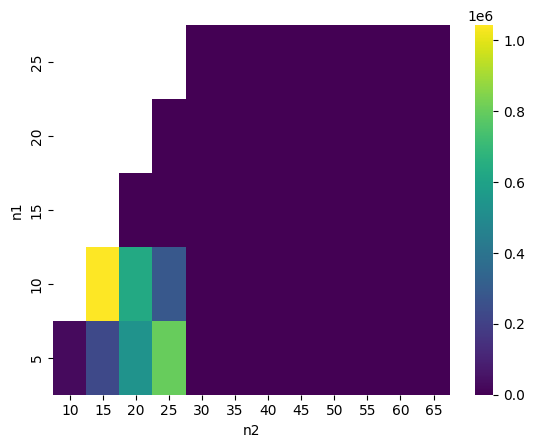

In [20]:
import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

# ใช้ scikit-optimize

In [23]:
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)

    def next(self):

        if not self.position:

            # On upwards trend, if price closes above
            # "entry" MA, go long

            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()

            # On downwards trend, if price closes below
            # "entry" MA, go short

            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()

        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position

        else:
            if (
                self.position.is_long
                and crossover(self.sma_exit, self.data.Close)
                or self.position.is_short
                and crossover(self.data.Close, self.sma_exit)
            ):

                self.position.close()


bt = Backtest(df, Sma4Cross, commission=0.002)

stats_skopt, heatmap, optimize_result = bt.optimize(
    n1=[10, 100],  # Note: For method="skopt", we
    n2=[20, 200],  # only need interval end-points
    n_enter=[10, 40],
    n_exit=[10, 30],
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize="Equity Final [$]",
    method="skopt",  # เพิ่มตรงนี้
    max_tries=200,
    random_state=0,
    return_heatmap=True,
    return_optimization=True,
)

Backtest.optimize:   0%|          | 0/200 [00:00<?, ?it/s]

Optimize value: [92, 194, 32, 17]


In [28]:
bt.plot()

/var/folders/0z/xgst8xk96cg3qsn14gk2xrpw0000gn/T/ipykernel_60640/651457420.py:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='3560', ...)

In [24]:
heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
33  40   32       25         46230.859268
85  182  35       24         68293.541679
92  194  32       17        311304.667051
Name: Equity Final [$], dtype: float64

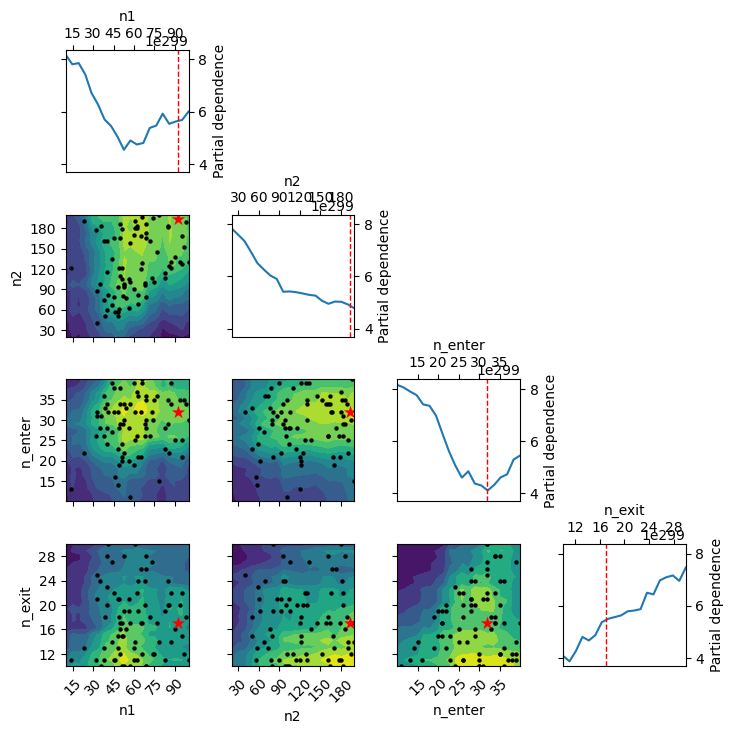

In [27]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=20)

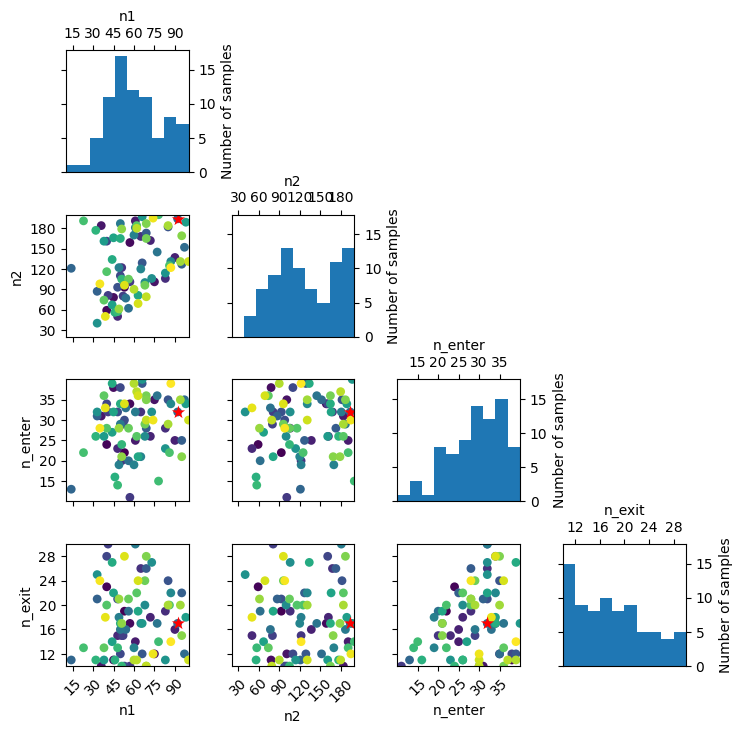

In [26]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)